# Render the movement decisions in attract mode

## First, a bunch of helper functions.

In [4]:
from IPython.display import display, HTML
# Increase the width
display(HTML("<style>.container { width:60% !important; }</style>"))


In [7]:
#Import libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

SCALE_FACTOR = 0.4
projected = lambda x,m: x + OFFSET if x < m else x - OFFSET

def scale(x,y,centre):
    x_mid,y_mid = centre
    x -= x_mid
    y -= y_mid
    x *= SCALE_FACTOR
    y *= SCALE_FACTOR
    x += x_mid
    y += y_mid
    return (x,y)

def getCentre(vertices):
    x_max = max([x for x,_ in vertices])
    x_min = min([x for x,_ in vertices])
    y_max = max([y for _,y in vertices])
    y_min = min([y for _,y in vertices])
    x_mid = int((x_max + x_min)/2)
    y_mid = int((y_max + y_min)/2)
    return (x_mid,y_mid)
    
"""
Create a web by traversing the vertices from a z of 0 to Z back and
forth.
"""
def create3DVertices(vertices):
    centre = getCentre(vertices)
    z1 = 40 # Hardcode nearest z position of web.
    Z = 100 # Hardcode furthest z position of web.
    d_vs = []
    # Each pass draws a 'rectangle' between the two z co-ordinates using
    # adjacent pairs of x and y co-ordinates.
    for i in range(0,len(vertices)-1):
        x1,y1 = vertices[i]
        d_vs += [(x1,y1,z1)]  # front side
        # Scale down the shape on the opposite side
        sx,sy = scale(x1,y1,centre)
        d_vs += [(sx,sy,Z)] # front side

        x2,y2 = vertices[i+1]
        # Scale down the shape on the opposite side
        sx,sy = scale(x2,y2,centre)
        d_vs += [(sx,sy,Z)] 
        d_vs += [(x2,y2,z1)] # opposite side
        d_vs += [(x1,y1,z1)] # front side
        d_vs += [(x2,y2,z1)] # opposite side

    # invert the y values so right side up
    max_y = max([y for _,y,_ in d_vs])
    y = np.array([max_y - y for _,y,_ in d_vs])
    x = np.array([[x for x,y,z in d_vs]])
    z = np.array([[z for x,y,z in d_vs]])

    return(x,y,z)

def setObjectVertices(l, scale=1, zpos=0, color="blue", xoffset=0, yoffset=0,inverty=True,invertx=False):
    max_y = max([l[i] for i in range(1,len(l),3)])
    max_x = max([l[i] for i in range(0,len(l),3)])
    i = 0
    vertices = []
    while l[i]:
        x,y,_ = l[i],l[i+1],l[i+2]
        x = max_x - x if invertx else x
        x += xoffset
        # invert the y values so right side up
        y = max_y - y if inverty else y
        y += yoffset
        i+=3
        conns = []
        while l[i]:
            if l[i] == -1:
                i+=1
                color = colors[l[i]]
            else:
                conns+=[(l[i],color)]
            i+=1
        vertices += [((x*scale,y*scale,zpos),conns)]
        i+=1
    return vertices

def setWebVertices(web_data):
    xs = [int(x) for x in ','.join([x for x in web_data.split() if ',' in x]).split(',')]
    l = [x*10 for x in xs]
    web_xy = [(l[i],l[i+1]) for i in range(0,len(l)-1,2)]
    # if the last value is 0 we ignore the last vertex pair
    if xs[-1] == 0:
        web_xy = web_xy[:-1]
    web_vertices = create3DVertices(web_xy)
    return web_vertices



In [36]:
def makeWebAndObjectDiagram(web_vertices, objects_vertices,filename="default.png",azim=135,elev=20):
    #Change the Size of Graph using Figsize
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection='3d')
    plt.rcParams['grid.color'] = "navy"
    # Make sure the plot starts at zero in all dimensions
    ax.plot_wireframe(np.zeros((1,2)), np.zeros((1,2)), np.zeros((1,2)), color ='black')
    ax.set_zlim(20,100)
    
    # Plot the web.
    x,y,z = web_vertices
    ax.set_zticklabels([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.plot_wireframe(x, y, z, color ='blue',zorder=10)
    #Rotate the web.
    ax.view_init(azim=azim,elev=elev,vertical_axis="y")
    # Set the background colors
    ax.xaxis.set_pane_color("black")
    ax.yaxis.set_pane_color("black")
    ax.zaxis.set_pane_color("black")

    # Plot the claw
    roll = 0
    zorder=2
    for object_vertices in objects_vertices:
        for (cx,cy,cz),conns in object_vertices:
            for conn,color in conns:
                x1,y1,z1 = object_vertices[conn-1][0]
                xs = np.array([[cx,x1]])
                ys = np.array([[cy,y1]])
                zs = np.array([[cz,z1]])
                ax.plot_wireframe(xs,ys,zs,color=color,zorder=zorder)
                zorder += 1
    # Save the image.
    plt.savefig(filename, transparent=True,bbox_inches='tight')
    return

### Web and Claw Data

In [12]:
claws = """
claw1:  dc.b 6,4,1,2,8,0
        dc.b 3,9,1,3,0
        dc.b 9,12,1,4,0
        dc.b 15,9,1,5,0
        dc.b 12,4,1,6,0
        dc.b 17,9,1,7,0
        dc.b 9,15,1,8,0
        dc.b 1,9,1,0,0

claw2:  dc.b 5,4,1,2,8,0
        dc.b 3,10,1,3,0
        dc.b 10,12,1,4,0
        dc.b 15,9,1,5,0
        dc.b 12,4,1,6,0
        dc.b 17,9,1,7,0
        dc.b 10,15,1,8,0
        dc.b 1,10,1,0,0

claw3:  dc.b 4,5,1,2,8,0
        dc.b 4,11,1,3,0
        dc.b 11,12,1,4,0
        dc.b 15,8,1,5,0
        dc.b 12,4,1,6,0
        dc.b 17,8,1,7,0
        dc.b 11,15,1,8,0
        dc.b 2,12,1,0,0

claw4:  dc.b 4,6,1,2,8,0
        dc.b 5,12,1,3,0
        dc.b 11,13,1,4,0
        dc.b 15,8,1,5,0
        dc.b 11,3,1,6,0
        dc.b 17,7,1,7,0
        dc.b 12,16,1,8,0
        dc.b 3,13,1,0,0

claw5:  dc.b 3,8,1,2,8,0
        dc.b 6,13,1,3,0
        dc.b 12,13,1,4,0
        dc.b 15,7,1,5,0
        dc.b 11,3,1,6,0
        dc.b 17,6,1,7,0
        dc.b 13,16,1,8,0
        dc.b 4,14,1,0,0

claw6:  dc.b 3,9,1,2,8,0
        dc.b 7,13,1,3,0
        dc.b 13,13,1,4,0
        dc.b 15,6,1,5,0
        dc.b 10,3,1,6,0
        dc.b 17,5,1,7,0
        dc.b 15,16,1,8,0
        dc.b 6,15,1,0,0

claw7:  dc.b 4,11,1,2,8,0
        dc.b 10,14,1,3,0
        dc.b 14,13,1,4,0
        dc.b 15,6,1,5,0
        dc.b 10,3,1,6,0
        dc.b 17,4,1,7,0
        dc.b 16,15,1,8,0
        dc.b 10,16,1,0,0

claw8:  dc.b 5,14,1,2,8,0
        dc.b 11,14,1,3,0
        dc.b 14,12,1,4,0
        dc.b 15,6,1,5,0
        dc.b 9,3,1,6,0
        dc.b 16,4,1,7,0
        dc.b 17,13,1,8,0
        dc.b 11,16,1,0,0
"""
claws_data = [[int(x) for x in ','.join([x for x in p.split() if ',' in x]).split(',')] 
              for p in claws.split('\n\n')]


In [107]:
web_lines = """
web7:   dc.w 15,7
        dc.w 7,6,5,5,3,5,1,7    ;dumb-bell
        dc.w 1,9,3,11,5,11,7,10
        dc.w 9,10,11,11,13,11,15,9
        dc.w 15,7,13,5,11,5,9,6,7,6,-1
""".split('\n')[2:-1]
web_data = ""
for ln in web_lines:
    web_data += ln

flippers = """
flipper:dc.b 2,5,1,2,6,0
        dc.b 16,13,1,3,0
        dc.b 12,9,1,4,0
        dc.b 16,5,1,5,0
        dc.b 2,13,1,6,0
        dc.b 6,9,1,0,0
"""
flippers_data = [[int(x) for x in ','.join([x for x in p.split() if ',' in x]).split(',')] 
              for p in flippers.split('\n\n')]
flipper_data = flippers_data[0]

## Render a web and explosion

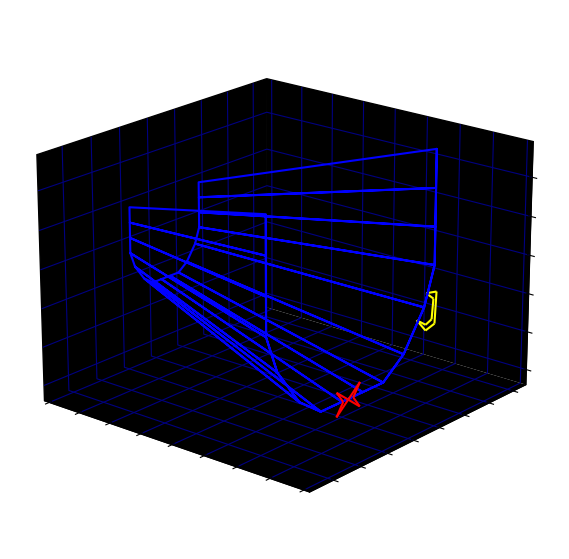

In [120]:
web_lines = """
web3:   dc.w 15,7
        dc.w 1,1,1,3,1,5,1,7    ;u
        dc.w 2,9,4,11,6,12,8,12
        dc.w 10,12,12,12,14,11,16,9
        dc.w 17,7,17,5,17,3,17,1,1,1,0
""".split('\n')[2:-1]
web_data = ""
for ln in web_lines:
    web_data += ln


web_vertices = setWebVertices(web_data)
claw_data = claws_data[6]
objects_vertices = []
objects_vertices += [setObjectVertices(flipper_data, scale=1.5, zpos=15,
                                     xoffset=108, yoffset=15, color="red", invertx=True)]
objects_vertices += [setObjectVertices(claw_data, scale=1.5, zpos=36,
                                     xoffset=18, yoffset=15, color="yellow", invertx=True)]
makeWebAndObjectDiagram(web_vertices, objects_vertices,filename=f"t2kdemo/demo_plane_left1.png", azim=130,elev=20)


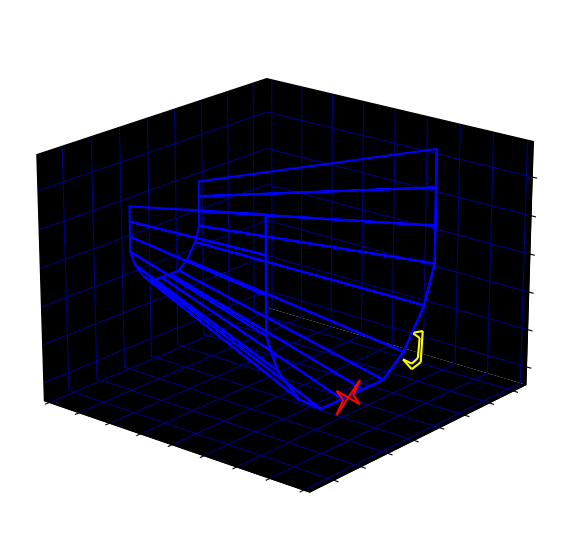

In [128]:
web_vertices = setWebVertices(web_data)
claw_data = claws_data[6]
objects_vertices = []
objects_vertices += [setObjectVertices(flipper_data, scale=1.5, zpos=15,
                                     xoffset=108, yoffset=15, color="red", invertx=True)]
objects_vertices += [setObjectVertices(claw_data, scale=1.5, zpos=40,
                                     xoffset=18, yoffset=-1, color="yellow", invertx=True)]
makeWebAndObjectDiagram(web_vertices, objects_vertices,filename=f"t2kdemo/demo_plane_left2.png", azim=130,elev=20)


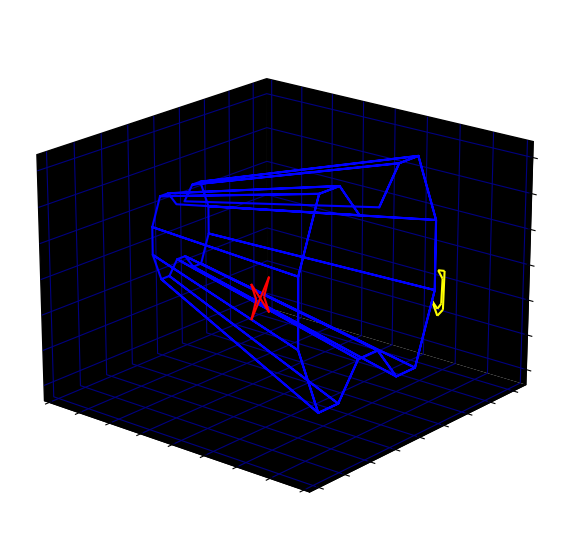

In [103]:
web_vertices = setWebVertices(web_data)
claw_data = claws_data[6]
objects_vertices = []
objects_vertices += [setObjectVertices(flipper_data, scale=1.2, zpos=40,
                                     xoffset=148, yoffset=25, color="red", invertx=True)]
objects_vertices += [setObjectVertices(claw_data, scale=1, zpos=36,
                                     xoffset=18, yoffset=15, color="yellow", invertx=True)]
makeWebAndObjectDiagram(web_vertices, objects_vertices,filename=f"t2kdemo/demo_left1.png", azim=130,elev=20)


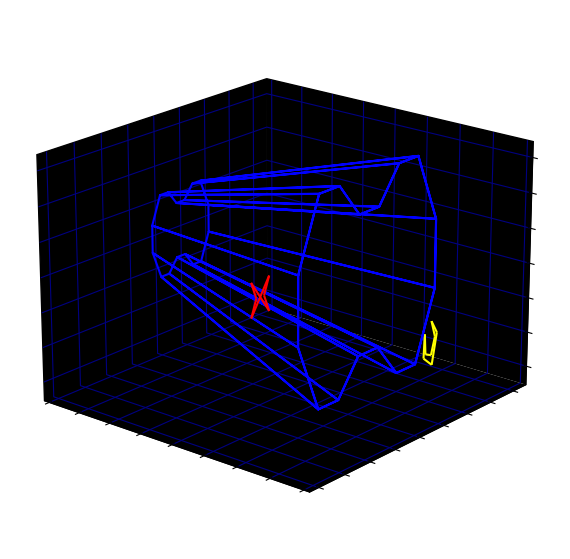

In [108]:
web_vertices = setWebVertices(web_data)
claw_data = claws_data[3]
objects_vertices = []
objects_vertices += [setObjectVertices(flipper_data, scale=1.2, zpos=40,
                                     xoffset=148, yoffset=25, color="red", invertx=True)]
objects_vertices += [setObjectVertices(claw_data, scale=1, zpos=38,
                                     xoffset=18, yoffset=0, color="yellow", invertx=True)]
makeWebAndObjectDiagram(web_vertices, objects_vertices,filename=f"t2kdemo/demo_left2.png", azim=130,elev=20)


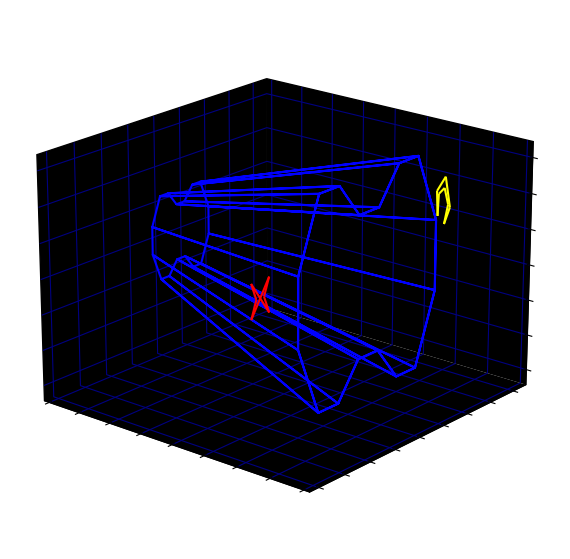

In [92]:
web_vertices = setWebVertices(web_data)
claw_data = claws_data[3]
objects_vertices = []
objects_vertices += [setObjectVertices(flipper_data, scale=1.2, zpos=40,
                                     xoffset=148, yoffset=25, color="red", invertx=True)]
objects_vertices += [setObjectVertices(claw_data, scale=1, zpos=32,
                                     xoffset=28, yoffset=40, color="yellow", invertx=True,inverty=False)]
makeWebAndObjectDiagram(web_vertices, objects_vertices,filename=f"t2kdemo/demo_left3.png", azim=130,elev=20)
